# TODO
- Parallelize cluster_approach over states
- Parallelize grid_approach over states
- Make two different .py files: cluster approach, grid approach.
- Make into folder: generating 'bounding_boxes'

- Make a separate prep_herb.py

- Correct eps size into haversine distance calculations

In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
import pandas as pd

In [2]:
# Get Herbarium data. Find some candidate locations.
occ = pd.read_csv("/data/cher/universe7/herbarium/data/MO-herbarium/occurrence.txt", sep="\t", on_bad_lines='skip')
occ = occ[[
    'gbifID', 'occurrenceID', # Joining Keys
    'speciesKey', 'species', # species
    'year', 'month', 'day', # date
    'habitat', 'locality', # descriptive text. I think this is most of the route / habitat info we would want. Looks like already OCR processed?
    'countryCode', 'stateProvince', 'county', 'municipality', # administrative
    'georeferenceSources','hasCoordinate', 'hasGeospatialIssues' ,'decimalLatitude', 'decimalLongitude']] # geospatial
    # 'level0Gid', 'level0Name', 'level1Gid', 'level1Name', 'level2Gid', 'level2Name', 'level3Gid', 'level3Name',]] # Has NAs. Above is more reliable.

habitat_info = occ[~occ['habitat'].isna()].copy()

/tmp/ipykernel_329770/903731494.py:2: DtypeWarning: Columns (49,56,57,59,60,61,63,64,65,66,67,68,73,74,77,78,79,83,89,91,92,95,97,98,99,100,101,102,103,105,106,107,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,135,137,138,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,160,162,163,164,167,168,171,173,174,177,178,182,183,184,185,186,189,190,191,192,193,194,195,196,197,198,199,200,204,208,209,210,211,220,221) have mixed types. Specify dtype option on import or set low_memory=False.
  occ = pd.read_csv("/data/cher/universe7/herbarium/data/MO-herbarium/occurrence.txt", sep="\t", on_bad_lines='skip')


In [4]:
# Random location
random_row = habitat_info[~habitat_info['habitat'].isna()].iloc[-4]
lat, lon = random_row['decimalLatitude'], random_row['decimalLongitude']

NAIP 
- Only 3 band RGB through WMS

In [13]:
import urllib.request
import rasterio
import matplotlib.pyplot as plt
import numpy as np


image_url = f"https://basemap.nationalmap.gov/arcgis/services/USGSImageryOnly/MapServer/WMSServer?service=WMS&version=1.1.1&request=GetMap&layers=0&styles=&width=256&height=256&srs=EPSG:4326&bbox={lon-0.005},{lat-0.005},{lon+0.005},{lat+0.005}&format=image/png"
out_file = f'/data/cher/universe7/herbarium/data/naip/1.png'

urllib.request.urlretrieve(image_url, out_file)

with rasterio.open(out_file) as src:
    # Get the number of bands
    num_bands = src.count
    print(f'The TIFF file has {num_bands} bands.')

('/data/cher/universe7/herbarium/data/naip/1.tiff',
 <http.client.HTTPMessage at 0x7f105f5980e0>)

Sentinel2
- Create csv file to push into CVGlobal 
    1) Cluster points state-by-state using DBSCAN into max areas of 512 x 512 meters --> cell
    2) Find center point of each cell

#### USA

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
from sklearn.cluster import DBSCAN
import numpy as np
from tqdm import tqdm
import os

In [235]:
def clean_data(data):
    
    data = data[~data['stateProvince'].isna()]

    data = data[
        pd.to_numeric(data['decimalLatitude'], errors='coerce').notnull() &
        pd.to_numeric(data['decimalLongitude'], errors='coerce').notnull()
    ]
    data['decimalLatitude'] = data['decimalLatitude'].astype(float)
    data['decimalLongitude'] = data['decimalLongitude'].astype(float)

    data['geometry'] = data.apply(
        lambda row: Point(row['decimalLongitude'], row['decimalLatitude']), axis=1
    )
    return data

In [236]:
# Get Herbarium data.
habitat_info = pd.read_csv("/data/cher/universe7/herbarium/data/MO-herbarium/occurrence.txt", sep="\t", on_bad_lines='skip')
habitat_info = habitat_info[[ 'occurrenceID', 'habitat' , 'stateProvince', 'decimalLatitude', 'decimalLongitude']]

data = habitat_info[~habitat_info['habitat'].isna()].copy()

# Convert to GeoDataFrame
data = clean_data(data[['occurrenceID','stateProvince','decimalLatitude', 'decimalLongitude']].copy())
data['geometry'] = data.apply(lambda row: Point(row['decimalLongitude'], row['decimalLatitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

/tmp/ipykernel_429802/1733575631.py:2: DtypeWarning: Columns (49,56,57,59,60,61,63,64,65,66,67,68,73,74,77,78,79,83,89,91,92,95,97,98,99,100,101,102,103,105,106,107,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,135,137,138,140,141,142,143,144,145,146,147,149,150,151,152,153,154,155,160,162,163,164,167,168,171,173,174,177,178,182,183,184,185,186,189,190,191,192,193,194,195,196,197,198,199,200,204,208,209,210,211,220,221) have mixed types. Specify dtype option on import or set low_memory=False.
  habitat_info = pd.read_csv("/data/cher/universe7/herbarium/data/MO-herbarium/occurrence.txt", sep="\t", on_bad_lines='skip')


1) DBSCAN still generates clustered grid cells outside of 512 meters.
- Instead we will do the following --> 
    1) generate DBSCAN clusters. Find points within those centers. 
    2) Points outside centers --> DBSCAN. Find points within those centers.

2) Fast --> Create grid for state. Find overlap of points. Return just those grids

In [198]:
from cluster import generate_radius, perform_dbscan, check_max_distances, check_max_haversine_distances

max_distance  = 512

gdf2 = gdf[gdf['stateProvince'] == 'New York'].copy()

# Perform initial DBSCAN clustering
radius_deg = generate_radius(max_distance)

labels = perform_dbscan(gdf2, max_distance, eps = radius_deg)
gdf2['cluster'] = labels
num_clusters = labels.max()

max_distances = check_max_distances(gdf2)

clusters_too_large = max_distances[max_distances['max_distance_meters'] > radius_deg]['cluster'].values

gdf_too_large = gdf2[gdf2['cluster'].isin(clusters_too_large)].copy()

print(len(clusters_too_large), gdf_too_large.shape[0])

cnt = 1
while len(clusters_too_large) > 0:
        for cluster in clusters_too_large:
                points = gdf_too_large[gdf_too_large['cluster'] == cluster]
                sampled_point = points.sample(n=1).iloc[0]
                buffer_size = (radius_deg / 111320) / 2  # Approx. degrees -- both ways
                lon, lat = sampled_point['decimalLongitude'], sampled_point['decimalLatitude']

                # Create bounding box
                bbox = box(lon - buffer_size, lat - buffer_size, lon + buffer_size, lat + buffer_size)

                # Assign points within the bounding box to the same cluster
                mask = (gdf_too_large['decimalLongitude'].between(lon - buffer_size, lon + buffer_size) &
                        gdf_too_large['decimalLatitude'].between(lat - buffer_size, lat + buffer_size))
                
                # If the sampled point's cluster has points nearby, assign them to a new cluster
                gdf_too_large.loc[mask, 'cluster'] = num_clusters + 1
                num_clusters += 1

        max_distances = check_max_distances(gdf_too_large)
        clusters_too_large = max_distances[max_distances['max_distance_meters'] > radius_deg]['cluster'].values
        print(num_clusters, len(clusters_too_large), gdf_too_large[gdf_too_large['cluster'].isin(clusters_too_large)].shape[0])

        cnt += 1


65 8816
50 7174
30 6493
24 6240
20 6125
19 5605
18 5487
17 5397
14 5318
12 5249
10 5217
10 5186
9 5146
9 5104
9 5042
8 4952
7 4929
7 4887
7 4853
7 4818
7 4797
7 4761
7 4722
7 4707
7 4690
7 4672
7 4644
6 4625
6 4604
5 4579
5 4552
5 4536
5 4525
5 4501
5 4489
5 4468
5 4450
5 4441
5 4415
5 4390
5 4378
5 4369
5 4361
5 4339
5 4304
5 4289
5 4226
5 4218
5 4211
5 4171
4 4154
4 4147
4 4132
4 4123
4 4108
4 4084
3 4075
3 4065
3 4059
3 4049
3 4043
3 4001
3 3984
3 3981
3 3975
3 3966
3 3949
3 3808
3 3792
3 3786
3 3745
3 3735
3 3725
3 3716
3 3709
3 3700
3 3692
3 3679
3 3664
3 3656
3 3604
3 3601
3 3588
3 3582
3 3570
3 3559
3 3548
3 3543
3 3537
3 3525
3 3519
3 3511
3 3507
3 3495
3 3476
3 3468
3 3465
3 3460
3 3441
3 3431
3 3417
3 3414
3 3408
3 3401
3 3391
3 3386
3 3371
3 3363
3 3357
3 3352
3 3343
3 3335
3 3324
3 3317
3 3310
3 3299
3 3295
3 3290
3 3280
3 3260
3 3236
3 3223
3 3220
3 3213
3 3209
3 3204
3 3199
3 3192
3 3175
3 3171
3 3155
3 3148
3 3143
3 3133
3 3116
3 3106
3 3090
3 3084
3 3080
3 3075
3 3059
3

In [237]:
from distance import generate_radius
from cluster import geocell_clustering

In [238]:
def process_state_clusters_to_files(input_gdf, radius = 512, output_geojson='./cache/locations/clusters.geojson', output_csv='./cache/locations/state_clusters.csv'):
    gdf = input_gdf.copy()
    
    # Create the output directories if they do not exist
    output_geojson_dir = os.path.dirname(output_geojson)
    output_csv_dir = os.path.dirname(output_csv)
    
    if output_geojson_dir and not os.path.exists(output_geojson_dir):
        os.makedirs(output_geojson_dir)
    
    if output_csv_dir and not os.path.exists(output_csv_dir):
        os.makedirs(output_csv_dir)

    # Initialize empty GeoDataFrame and DataFrame for saving results iteratively
    all_bounding_boxes = gpd.GeoDataFrame(columns=['state_cluster', 'lat', 'lon' ,'geometry'], geometry='geometry')
    combined_clusters_df = pd.DataFrame()

    radius_deg = generate_radius(radius)

    # Create empty files if they don't exist or overwrite existing ones
    combined_clusters_df.to_csv(output_csv, index=False)

    # Process each state
    states = gdf['stateProvince'].unique()
    for state in tqdm(states, desc="Processing States"):
        print(state)
        gdf_s = gdf[gdf['stateProvince'] == state].copy()

        # Convert to numpy array for DBSCAN
        coords = np.array(list(zip(gdf_s['decimalLongitude'], gdf_s['decimalLatitude'])))

        # Use DBSCAN to group points within 512 meters (approx. 0.0046 degrees)
        gdf_s = geocell_clustering(gdf_s, state, radius)

        # Save occurrence_ID and state_cluster to a CSV iteratively
        gdf_s[['occurrenceID', 'state_cluster']].to_csv(output_csv, mode='a', header=False, index=False)

        # Create bounding boxes for each cluster
        # _create_bbox
        bounding_boxes = []
        for label in gdf_s['state_cluster'].unique():
            cluster_points = gdf_s[gdf_s['state_cluster'] == label]
            minx, miny = cluster_points.geometry.x.min() - (radius_deg / 2), cluster_points.geometry.y.min() - (radius_deg / 2)
            maxx, maxy = cluster_points.geometry.x.max() + (radius_deg /  2), cluster_points.geometry.y.max() + (radius_deg / 2)
            bbox = box(minx, miny, maxx, maxy)
            centroid = bbox.centroid

            bounding_boxes.append({
                'state_cluster': label,
                'lat': centroid.y,
                'lon': centroid.x,
                'geometry': bbox,

            })
            
        # Convert bounding boxes to GeoDataFrame and save to GeoJSON iteratively
        bbox_gdf = gpd.GeoDataFrame(bounding_boxes)

        # If the GeoJSON file doesn't exist, create it
        if not os.path.exists(output_geojson):
            bbox_gdf.to_file(output_geojson, driver="GeoJSON")
        else:
            bbox_gdf.to_file(output_geojson, driver="GeoJSON", mode='a')

    print(f"Saved all clusters to {output_geojson}")
    print(f"Saved occurrence_ID and state_cluster mapping to {output_csv}")

In [240]:
# Process clusters and save results to GeoJSON and CSV files
# Not set up to check whether already exists or not. Pretty quick, so re-run with full occurrences as needed.
# process_state_clusters_to_files(gdf)

process_state_clusters_to_files(gdf[gdf['stateProvince'] == 'New York'], radius=512)

Processing States:   0%|          | 0/1 [00:00<?, ?it/s]

New York
Performed initial DBSCAN
2605 49 7336
2654 32 6742
2686 24 6450
2710 22 5965
2732 20 5868
2752 17 5737
2769 15 5657
2784 12 5552
2796 11 5495
2807 10 5463
2817 10 5444
2827 9 5383
2836 9 5351
2845 8 5296
2853 7 5242
2860 7 5214
2867 7 5031
2874 7 4977
2881 7 4951
2888 7 4926
2895 7 4900
2902 7 4827
2909 6 4777
2915 6 4568
2921 6 4554
2927 6 4535
2933 6 4508
2939 5 4477
2944 5 4446
2949 5 4361
2954 5 4348
2959 5 4333
2964 5 4308
2969 5 4296
2974 5 4271
2979 5 4250
2984 5 4242
2989 5 4229
2994 5 4180
2999 5 4153
3004 5 4141
3009 5 4111
3014 5 4065
3019 5 4054
3024 5 4023
3029 4 3993
3033 4 3983
3037 4 3968
3041 4 3961
3045 4 3947
3049 4 3931
3053 4 3893
3057 4 3884
3061 4 3880
3065 4 3869
3069 4 3862
3073 3 3851
3076 3 3847
3079 3 3840
3082 3 3826
3085 3 3821
3088 3 3815
3091 3 3810
3094 3 3802
3097 3 3797
3100 3 3794
3103 3 3790
3106 3 3782
3109 3 3776
3112 3 3768
3115 3 3760
3118 3 3754
3121 3 3748
3124 3 3735
3127 3 3731
3130 3 3725
3133 3 3703
3136 3 3691
3139 3 3685
3142 3 

Processing States:   0%|          | 0/1 [07:21<?, ?it/s]


KeyboardInterrupt: 

In [145]:
clusters = gpd.read_file('/data/cher/universe7/herbarium/eda/cache/locations/clusters.geojson')
cluster_assignments = pd.read_csv('/data/cher/universe7/herbarium/eda/cache/locations/state_clusters.csv', header = None)
# cluster_assignments = pd.read_csv('/data/cher/universe7/herbarium/data_prep/CVGlobal/cache/locations/state_clusters.csv', header = None)
cluster_assignments.columns = ['occurrenceID', 'state_cluster']

In [134]:
# Get general info.
num_bbox_per_state = clusters['state_cluster'].str.split('_').str[0].value_counts()
num_images_per_state = cluster_assignments['state_cluster'].str.split('_').str[0].value_counts()
num_images_per_cluster = num_images_per_state / num_bbox_per_state

print(num_bbox_per_state, num_images_per_state, num_images_per_cluster)

display(num_images_per_cluster.sort_values(ascending = False))

state_cluster
Michigan    788
Name: count, dtype: int64 state_cluster
Michigan    4479
Name: count, dtype: int64 state_cluster
Michigan    5.68401
Name: count, dtype: float64


state_cluster
Michigan    5.68401
Name: count, dtype: float64

In [34]:
import pandas as pd
import geopandas as gpd
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point

In [71]:
### sanity checks
# Are places assigned to the same cluster within 512 meters of one another?
habitat_gdf_w_bbox_cluster = gdf.merge(cluster_assignments, on = ['occurrenceID'])

ex = habitat_gdf_w_bbox_cluster[habitat_gdf_w_bbox_cluster['stateProvince'] == 'New York']

In [30]:
# Function to calculate max distance within each cluster
def max_distance(group):
    coords = group[['decimalLatitude', 'decimalLongitude']].to_numpy()
    if len(coords) > 1:
        # Calculate pairwise distances
        distances = pdist(coords, metric='euclidean')
        max_dist = distances.max()
    else:
        max_dist = 0  # Only one point, no distance to calculate
    return max_dist

# Apply the function to each state_cluster
# max_distances = ex.groupby('state_cluster').apply(max_haversine_distance).reset_index()
# max_distances.columns = ['state_cluster', 'max_distance_meters']

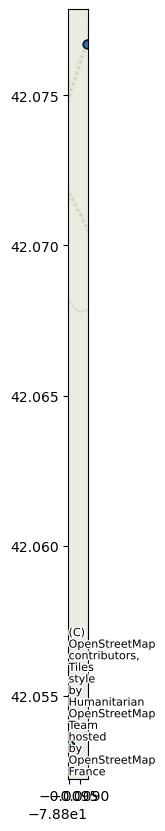

In [76]:
new_york_47 = ex[ex['state_cluster'] == 'New York_47']
new_york_47.crs = 'EPSG:4326'
import contextily as ctx

# Create a static plot with contextily basemap
ax = new_york_47.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=new_york_47.crs.to_string())

In [75]:
max_distances.sort_values('max_distance_meters', ascending=False).head(20)

,state_cluster,max_distance_meters
1,New York_1,2592.304639
668,New York_16,2460.592580
890,New York_18,2282.242930
2048,New York_69,2018.259393
824,New York_174,1855.487505
1860,New York_52,1852.704612
1180,New York_206,1830.770140
446,New York_14,1828.057101
1615,New York_3,1784.465375
469,New York_142,1782.757237


In [ ]:
# Use grid cells across US that have occurrences for query of images.
# sentinal2_key.csv -- Source - gbif, key - numeric_key, lat, lon  
# obs_id2key .csv -- [Source, obs_id, key, bbox_bounds]

In [17]:
# ## Inefficient method -- Grid across state. point-in-polygon.
    # 1) Create equal spatial grid of CA (512M x 512M)
    # 2) Find center point of each cell
    # 3) Remove grids outside CA
    # 4) Calculate # of cells with observation
    # 5) Calculate # of observations per cell

# # California ~4 min

# ## Inefficient method
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# from shapely.geometry import box, Point
# from joblib import Parallel, delayed
# from tqdm import tqdm

# def build_grid(cell_size_m, bbox):
#     # Approximate conversion factors
#     deg_per_meter_lat = 1 / 111000  # degrees per meter for latitude
#     deg_per_meter_lon = 1 / (111000 * np.cos(np.radians((bbox[1] + bbox[3]) / 2)))  # degrees per meter for longitude

#     # Calculate the number of rows and columns
#     lat_range = bbox[3] - bbox[1]  # degrees of latitude
#     lon_range = bbox[2] - bbox[0]  # degrees of longitude

#     nrows = int(np.ceil(lat_range / (cell_size_m * deg_per_meter_lat)))
#     ncols = int(np.ceil(lon_range / (cell_size_m * deg_per_meter_lon)))

#     # Use tqdm to create a progress bar
#     tasks = [(i, j, cell_size_m, deg_per_meter_lat, deg_per_meter_lon, bbox) for i in range(nrows) for j in range(ncols)]
#     with Parallel(n_jobs=-1) as parallel:
#         grid_polygons = list(tqdm(parallel(delayed(create_cell)(*task) for task in tasks), total=len(tasks)))

#     return grid_polygons

# def create_cell(i, j, cell_size_m, deg_per_meter_lat, deg_per_meter_lon, bbox):
#     # Calculate the corners of the cell
#     min_lat = bbox[1] + i * cell_size_m * deg_per_meter_lat
#     max_lat = bbox[1] + (i + 1) * cell_size_m * deg_per_meter_lat
#     min_lon = bbox[0] + j * cell_size_m * deg_per_meter_lon
#     max_lon = bbox[0] + (j + 1) * cell_size_m * deg_per_meter_lon

#     # Create a polygon for the cell
#     return box(min_lon, min_lat, max_lon, max_lat)

# california = gpd.read_file('/data/cher/universe7/herbarium/data/California_State_Boundary.geojson')
# grid_polygons = build_grid(cell_size_m = 1024, bbox = california.total_bounds)

# # Create a GeoDataFrame for the grid
# grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons)
# grid_gdf.set_crs(california.crs, inplace=True)
# grid_within_ca = gpd.sjoin(grid_gdf, california, how='inner', predicate='intersects')

# # Create a DataFrame with center points of remaining cells
# grid_within_ca = gpd.GeoDataFrame(grid_within_ca[['geometry']], geometry='geometry')
# grid_centers = grid_within_ca.geometry.apply(lambda geom: geom.centroid)
# centroid_points = pd.DataFrame(grid_centers.apply(lambda point: (point.x, point.y)).tolist(), columns=['Longitude', 'Latitude'])

# CA_data = habitat_info[habitat_info['stateProvince'] == 'California']
# # Remove rows with non-numeric latitudes or longitudes
# CA_data = clean_data(CA_data[['occurrenceID','stateProvince','decimalLatitude', 'decimalLongitude']].copy())
# CA_data_gdf = gpd.GeoDataFrame(CA_data, geometry='geometry')

# CA_data_gdf.set_crs(grid_within_ca.crs, inplace=True)
# observations_in_cells = gpd.sjoin(CA_data_gdf, grid_within_ca, how='inner', predicate='within')

# # Calculate the number of cells with at least one observation
# num_cells_with_observations = observations_in_cells['index_right'].nunique()
# observations_per_cell = observations_in_cells.groupby('index_right').size().reset_index(name='observations_count').sort_values('observations_count', ascending = False)

# print(f"Occurrences: {CA_data.shape[0]}\nSatellite images: {num_cells_with_observations}\nDescriptions per image {np.mean(observations_per_cell.observations_count)}")

Occurrences: 12654
Satellite images: 4798
Descriptions per image 2.634014172571905
